In [3]:
import sys
!{sys.executable} -m pip install plotly

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
  Using cached plotly-5.22.0-py3-none-any.whl.metadata (7.1 kB)
Using cached plotly-5.22.0-py3-none-any.whl (16.4 MB)


In [1]:
import os
import re
import csv
import json
import random
import numpy as np
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from iso639 import languages
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import scipy
import math

# Set notebook mode to work in offline
pyo.init_notebook_mode()

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tldextract import extract
import matplotlib.cm as cm
  
import urllib.request as urlopen
from textwrap import wrap

from transformers import pipeline
import textstat
import pyLDAvis
from biterm.cbtm import oBTM 
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms, topic_summuary # helper functions

import compress_pickle as pickle
from tqdm import tqdm

# Load dataset

In [2]:
data_file = '/data/audioset/audio_transcripts/train.tsv'
# data_file = '/gscratch/scrubbed/wagnew2/cv-corpus-17.0-2024-03-15/en/train.tsv'

try:
    mozilla_df=pd.read_csv(data_file, sep='\t')
except Exception as e:
    print("ERROR", e)

mozilla_df['transcript'] = mozilla_df['sentence']
mozilla_df

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/pandas/io/parsers/c_parser_wrapper.py:373: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/tmp/ipykernel_2225382/877736569.py:5: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



client_id  \
0        f15d2e0fd19c04421174108a8c02c3c2ef8e76365cdcc4...   
1        f1619cc90b57fc09cad0f22e0034b9b70f9e1730043bba...   
2        f1619cc90b57fc09cad0f22e0034b9b70f9e1730043bba...   
3        f1619cc90b57fc09cad0f22e0034b9b70f9e1730043bba...   
4        f161e283a59077cdca316bcf7e2f46021a30a163548197...   
...                                                    ...   
1100821  372293e65cdab88771e028a4351651ab2eff64438ddafc...   
1100822  372293e65cdab88771e028a4351651ab2eff64438ddafc...   
1100823  372293e65cdab88771e028a4351651ab2eff64438ddafc...   
1100824  372293e65cdab88771e028a4351651ab2eff64438ddafc...   
1100825  372293e65cdab88771e028a4351651ab2eff64438ddafc...   

                                 path  \
0        common_voice_en_17924809.mp3   
1        common_voice_en_19612700.mp3   
2        common_voice_en_19612701.mp3   
3        common_voice_en_19612703.mp3   
4          common_voice_en_212609.mp3   
...                               ...   
1100821  common_voice_en_40137091.mp3   
1100822  common_voice_en_40137115.mp3   
1100823  common_voice_en_40165947.mp3   
1100824  common_voice_en_40166196.mp3   
1100825  common_voice_en_40166259.mp3   

                                               sentence_id  \
0        05001a328ff9f6589eb0ca7b8df65cd9662698a85e204e...   
1        1ad0ca90c9d90d3864a07ffe269d29cf746d810d7471b2...   
2        1ad9e86d5d4886d66460e453a00e844fee8b48dfc7d589...   
3        1ae9db10a316627e0045280707d781f04f1a9f52537d4a...   
4        0438b75e57e8141ec5080893c825da6c301342a5b5b1cc...   
...                                                    ...   
1100821  e9943928afa82f1bf7cd21f1af93bd85bd84787d801b9e...   
1100822  e96ad5ab6c411a3df475e89b0d6ad88a0aa5786023ce4d...   
1100823  e9c54968c877c8a0d16bbb33cc5c7d7a583ebdf47c0766...   
1100824  e9c377663e2d2c92fb8fb3cbfbddd3ea544b0f30581e48...   
1100825  e9cd09d703a9b5bfb8449c3781a8d43ef1b087f0839331...   

                                                  sentence sentence_domain  \
0        Every evening, the dogs in our neighbourhood a...             NaN   
1                            A donor has since been found.             NaN   
2        New York at that time had become a premier cen...             NaN   
3        Weise proceeded into the main corridor of the ...             NaN   
4                                      When can I see him?             NaN   
...                                                    ...             ...   
1100821  Invited to speak about her life at many events...             NaN   
1100822  Examples include Slashdot, LiveJournal, BlogSpot.             NaN   
1100823  Kirkbride was born in Halifax, West Riding of ...             NaN   
1100824  From that time until now the cover changed eac...             NaN   
1100825  The park can be accessed from the lagoon north...             NaN   

         up_votes  down_votes      age          gender  \
0               2           0      NaN             NaN   
1               2           0      NaN             NaN   
2               2           1      NaN             NaN   
3               2           1      NaN             NaN   
4               2           1      NaN             NaN   
...           ...         ...      ...             ...   
1100821         2           0  fifties  male_masculine   
1100822         2           0  fifties  male_masculine   
1100823         2           0  fifties  male_masculine   
1100824         4           0  fifties  male_masculine   
1100825         2           0  fifties  male_masculine   

                                   accents  variant locale  segment  \
0                                      NaN      NaN     en      NaN   
1                                      NaN      NaN     en      NaN   
2                                      NaN      NaN     en      NaN   
3                                      NaN      NaN     en      NaN   
4                                      NaN      NaN     en      NaN   
...   

In [3]:
def get_full_lang(lang):
    full_lang = None
    if lang == 'None':
        return full_lang

    try:
        full_lang = languages.get(alpha2=lang).name
    except Exception as e:
        if lang == 'jw':
            full_lang = 'Javanese'
        elif lang == 'haw':
            full_lang = 'Hawaiian'
        elif lang == 'iw':
            full_lang = 'Modern Hebrew'
        else:
            print(lang, e)
    return full_lang

mozilla_df['full_language'] = mozilla_df['locale'].apply(get_full_lang)

In [7]:
mozilla_df['variant'].value_counts()

Series([], Name: variant, dtype: int64)

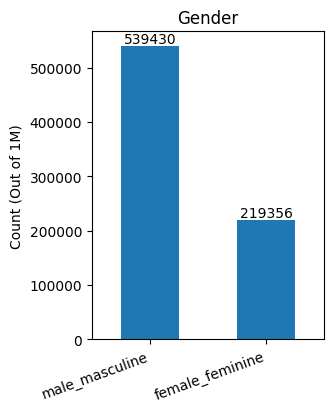

In [17]:
barplot = mozilla_df['gender'].value_counts().plot(kind='bar', figsize=(3, 4))

plt.title('Gender')
plt.ylabel('Count (Out of 1M)')
# plt.ylim((0, 55000))
plt.bar_label(barplot.containers[0],)
plt.xticks(rotation=20, ha='right')
plt.show()

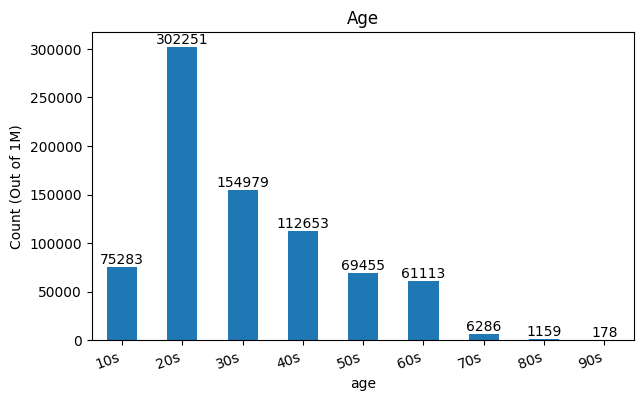

In [30]:
AGE_NAMES = {
    'teens': '10s',
    'twenties': '20s',
    'thirties': '30s',
    'fourties': '40s',
    'fifties': '50s',
    'sixties': '60s',
    'seventies': '70s',
    'eighties': '80s',
    'nineties': '90s',
}

age_count_dict = defaultdict(int)
for a in mozilla_df['age'].tolist():
    if str(a) != 'nan':
        g = AGE_NAMES[a]
        age_count_dict[g] += 1

plot_df = pd.DataFrame({
    'age': list(age_count_dict.keys()),
    'count': list(age_count_dict.values())
})
barplot = plot_df.sort_values('age').plot(kind='bar', x='age', y='count', figsize=(7, 4), legend=False)

plt.title('Age')
plt.ylabel('Count (Out of 1M)')
# plt.ylim((0, 55000))
plt.bar_label(barplot.containers[0],)
plt.xticks(rotation=20, ha='right')
plt.show()

In [51]:
mozilla_df['accents'].value_counts()[:20]

United States English                                   278647
England English                                          84813
India and South Asia (India, Pakistan, Sri Lanka)        82150
Canadian English                                         55574
German English,Non native speaker                        49591
Australian English                                       35106
Southern African (South Africa, Zimbabwe, Namibia)       17182
Scottish English                                         12509
Northern Irish                                            9975
Irish English                                             6781
New Zealand English                                       6043
Filipino                                                  4705
Hong Kong English                                         3084
Singaporean English                                       2851
Liverpool English,Lancashire English,England English      2574
England English,New Zealand English                    

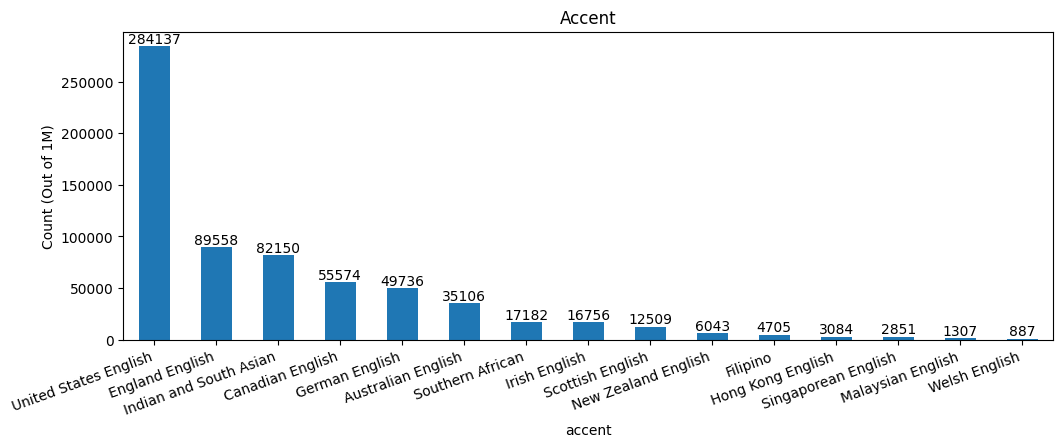

In [53]:
ACCENT_NAMES = {
    'Northern Irish': 'Irish English',
    'Liverpool English,Lancashire English,England English': 'England English',
    'India and South Asia (India, Pakistan, Sri Lanka)': 'Indian and South Asian',
    'Southern African (South Africa, Zimbabwe, Namibia)': 'Southern African',
    'German English,Non native speaker': 'German English',
    'United States English,Midwestern,Low,Demure': 'United States English',
    'United States English,Transatlantic English': 'United States English',
    'England English,New Zealand English': 'England English',
    'United States English,England English': 'United States English',
    'United States English,Scandinavian': 'United States English',
}

accent_count_dict = defaultdict(int)
for a in mozilla_df['accents'].tolist():
    if str(a) != 'nan':
        g = ACCENT_NAMES[a] if a in ACCENT_NAMES else a
        accent_count_dict[g] += 1

sorted_accent_count_dict = {
    k: v for k, v in sorted(accent_count_dict.items(), key=lambda item: item[1], reverse=True)
}
sorted_accents = list(sorted_accent_count_dict.keys())
sorted_counts = list(sorted_accent_count_dict.values())

top_num = 15

plot_df = pd.DataFrame({
    'accent': sorted_accents[:top_num],
    'count': sorted_counts[:top_num],
})

barplot = plot_df.sort_values('count', ascending=False).plot(
    kind='bar', x='accent', y='count', figsize=(12, 4), legend=False
)

plt.title('Accent')
plt.ylabel('Count (Out of 1M)')
# plt.ylim((0, 55000))
plt.bar_label(barplot.containers[0],)
plt.xticks(rotation=20, ha='right')
plt.show()

# Common words by demographics

In [64]:
pattern = re.compile(r"[^A-Za-z ']+")

def clean_caption(caption, as_set=False, root=''):
    cleaned_caption = pattern.sub('', caption.strip().lower())
    if root != '':
        regex = re.compile(root)
        cleaned_caption = regex.sub('', cleaned_caption)

    if as_set: # only return unique words in caption
        return set(cleaned_caption.split(' '))          
    else:
        return cleaned_caption

def get_common_words(samples, root=''):
    # get word dict
    word_freq = defaultdict(int)
    for s in samples:
        for word in clean_caption(s, as_set=True, root=root):
            if len(word) > 2:
                if word.lower() not in STOPWORDS and not bool(re.search(r'\d', word)):
                    if root == '' or not bool(re.search(root, word)):
                        word_freq[word.lower()] += 1

    # sort word dict
    sorted_word_freq = {k: v for k, v in sorted(
        word_freq.items(), key=lambda item: item[1], reverse=True
    )}
    return sorted_word_freq

def graph_common_words(keyword_transcripts, keyword):
    keyword_words = get_common_words(keyword_transcripts)
#     print(len(keyword_words))

    sorted_words = list(keyword_words.keys())
    sorted_counts = list(keyword_words.values())

    top_num = 25

    plot_df = pd.DataFrame({
        'word': sorted_words[:top_num],
        'count': sorted_counts[:top_num],
    })

    barplot = plot_df.sort_values('count', ascending=False).plot(
        kind='bar',y='count',x='word', legend=False,
        figsize=(9, 3)
    )
    plt.title(keyword + ' (out of ' + str(len(keyword_transcripts)) + ' samples): Top 25 common words')
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=40, ha='right')
    plt.bar_label(barplot.containers[0])
#         plt.ylim(0, 55000)
    plt.show()

def get_wordclouds(transcripts, root=''):
    cleaned_transcripts = []
    for transcript in transcripts:
        cleaned_transcripts.append(" ".join(clean_caption(transcript, as_set=True, root=root)))

    fig, ax = plt.subplots(figsize=(20,12))
    wordcloud = WordCloud(width=800, height=400,
        background_color="white" # max_font_size=50, min_font_size=10, max_words=100
    ).generate(' '.join(cleaned_transcripts))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    plt.show()

In [56]:
mozilla_df['gender'].unique()

array([nan, 'male_masculine', 'female_feminine'], dtype=object)

male_masculine


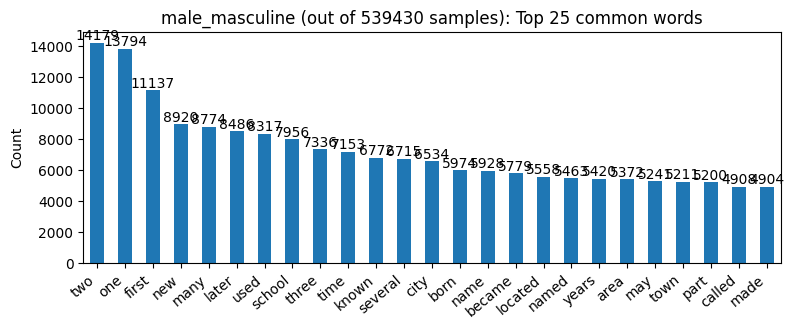

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarni

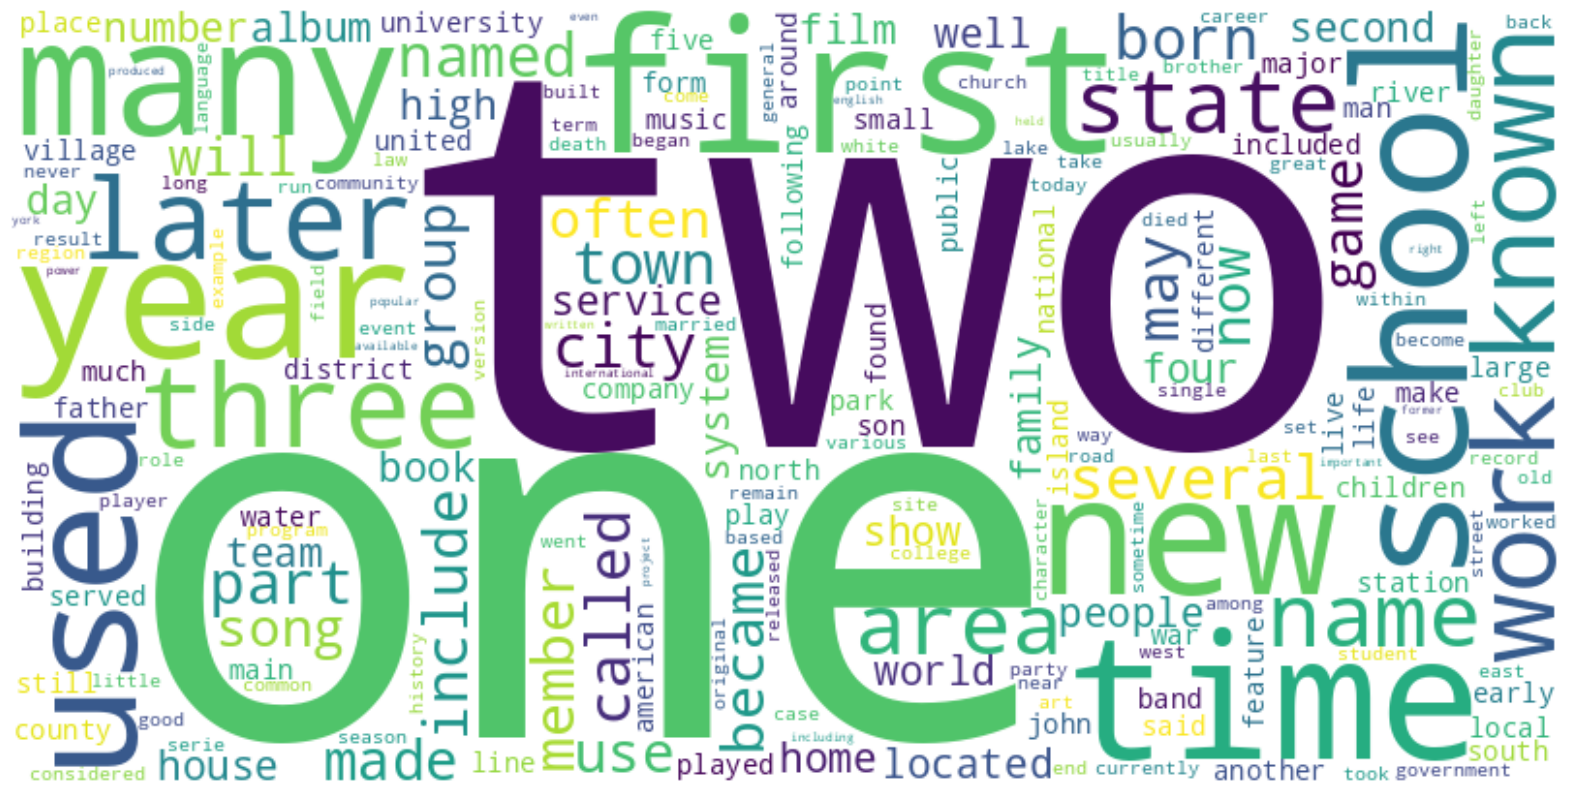

female_feminine


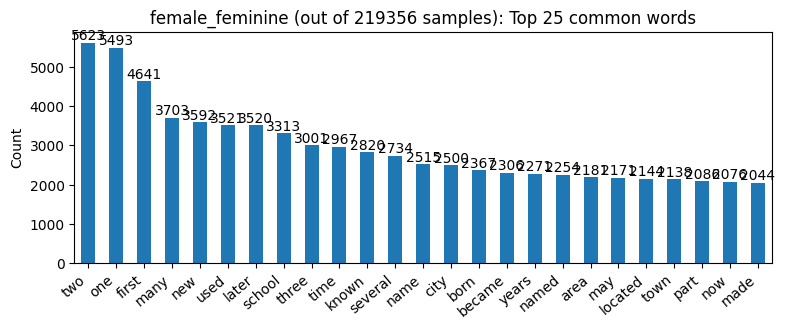

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/home/hongrach/anaconda3/envs/datacomp/lib/python3.10/site-packages/wordcloud/wordcloud.py:522: DeprecationWarni

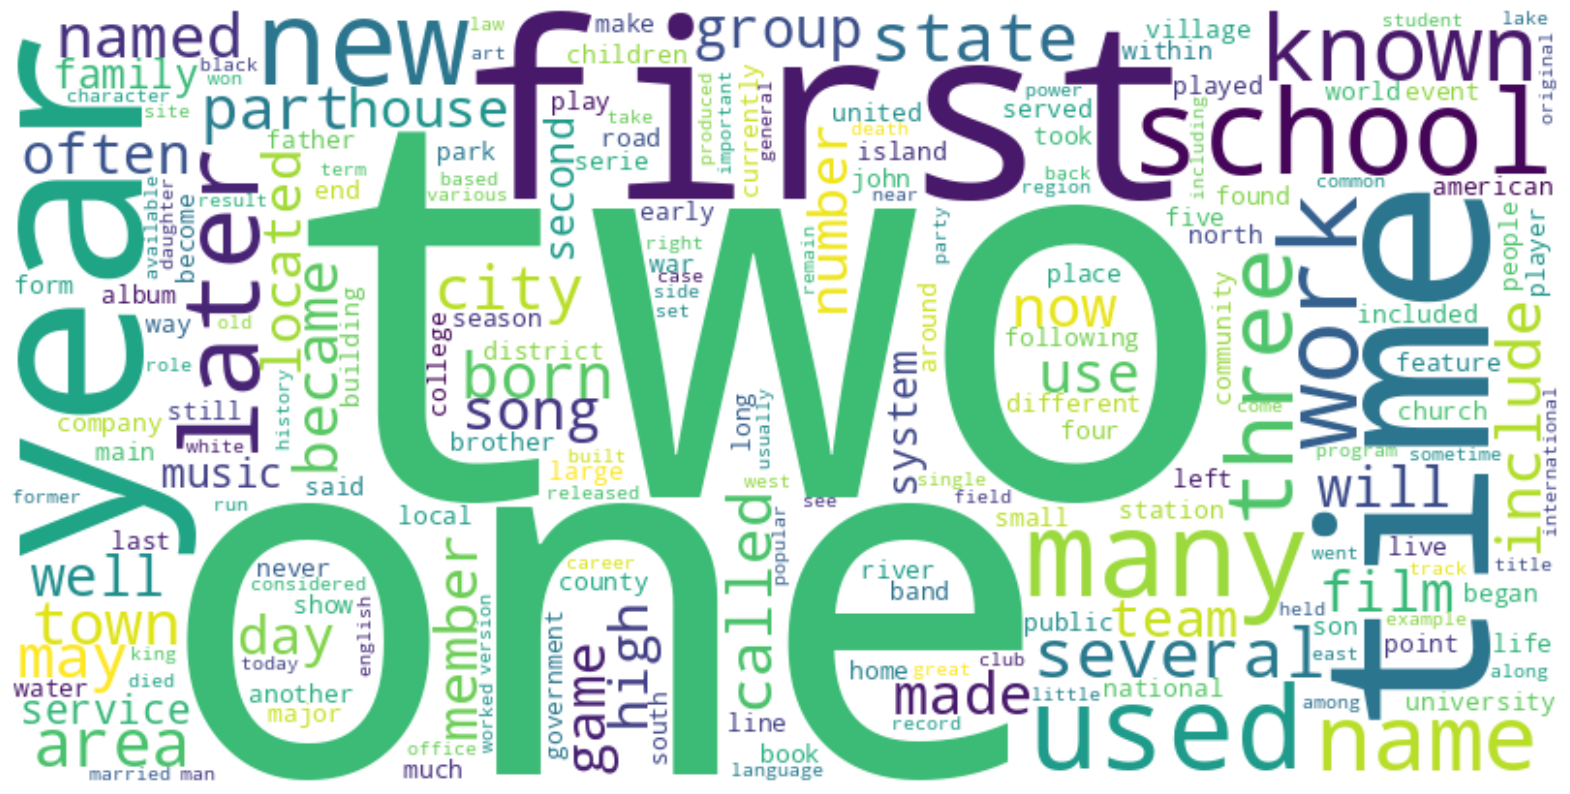

In [65]:
for g in mozilla_df['gender'].unique():
    if str(g) != 'nan':
        print(g)
        g_df = mozilla_df[mozilla_df['gender'] == g]
        g_transcripts = g_df['transcript'].tolist()
        graph_common_words(g_transcripts, g)
        get_wordclouds(g_transcripts)
        

thirties


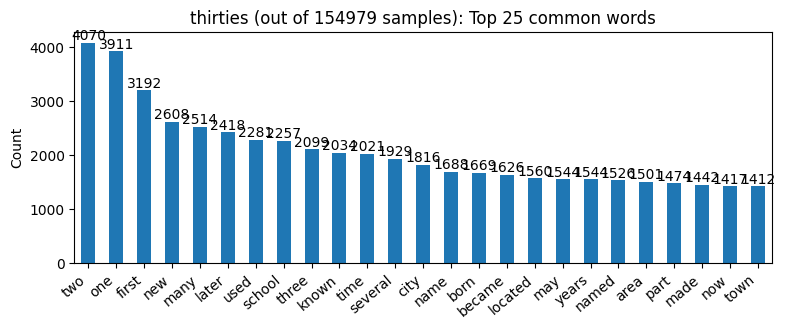

teens


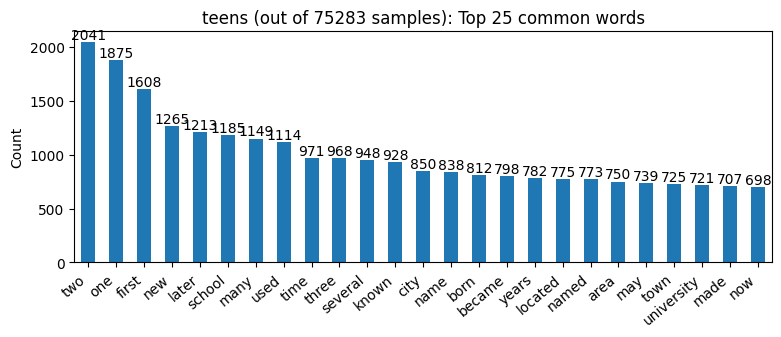

twenties


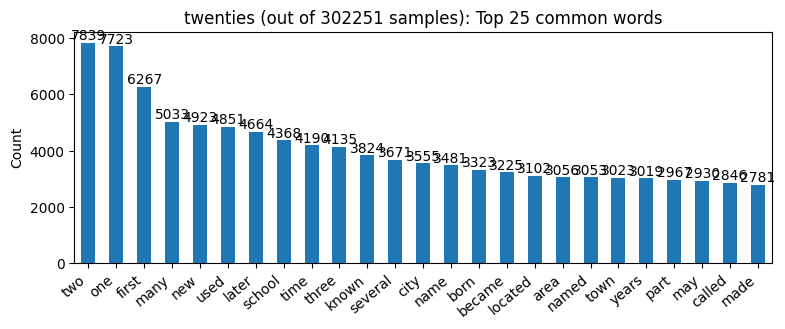

fourties


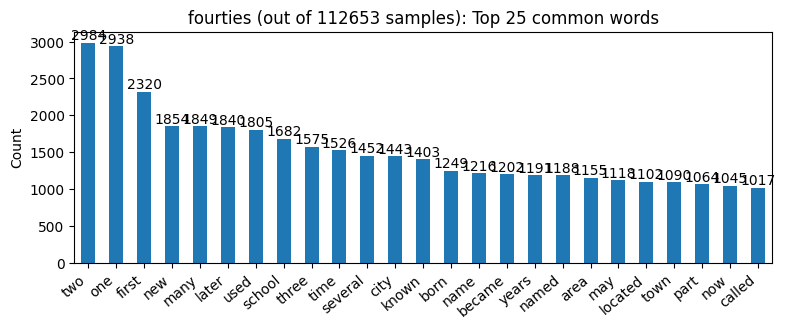

fifties


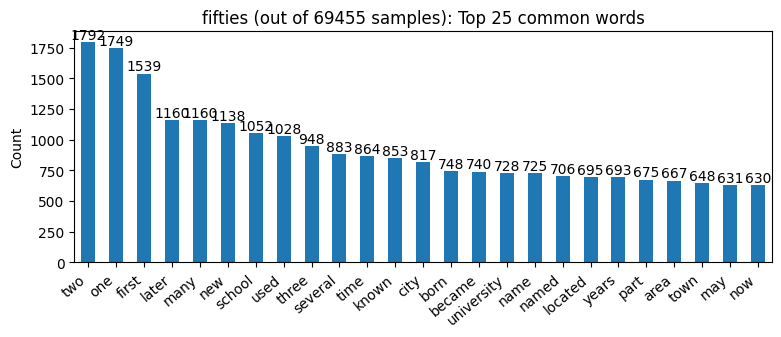

sixties


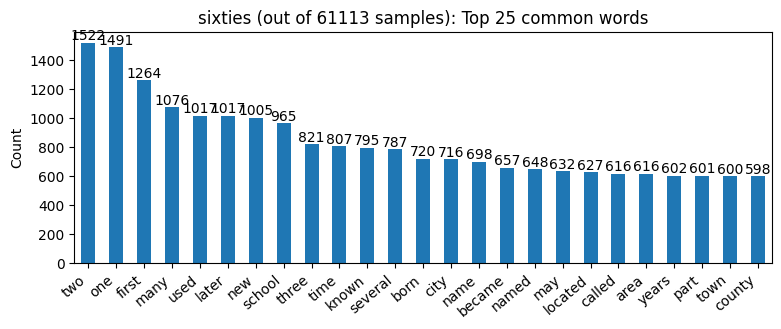

seventies


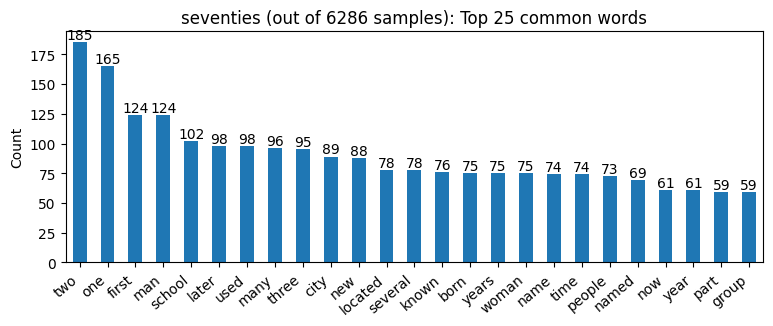

eighties


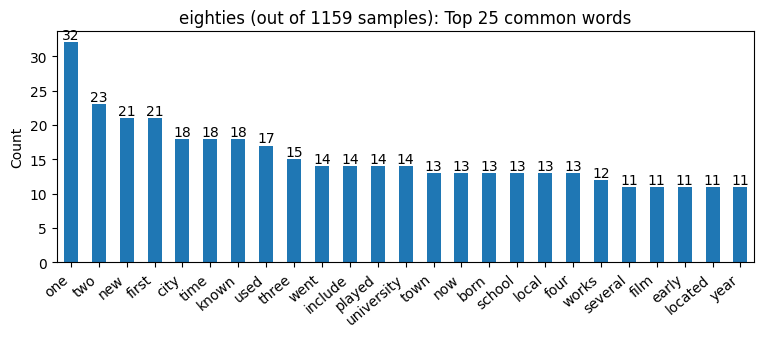

nineties


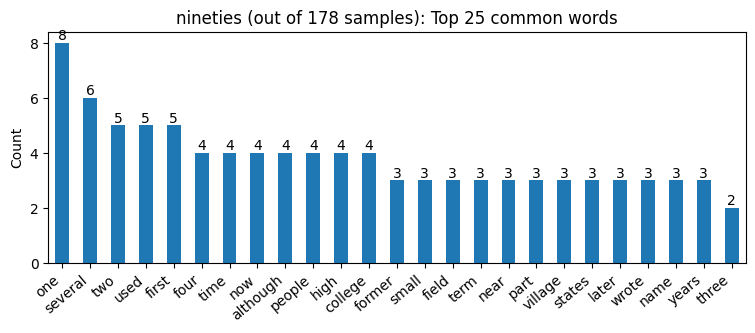

In [66]:
for g in mozilla_df['age'].unique():
    if str(g) != 'nan':
        print(g)
        g_df = mozilla_df[mozilla_df['age'] == g]
        g_transcripts = g_df['transcript'].tolist()
        graph_common_words(g_transcripts, g)